In [2]:
# Import dependencies
import sqlalchemy
from sqlalchemy import create_engine, inspect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pprint import pprint
import json
import math

%run functions.ipynb

## Import datasets

In [3]:
# Import the data
engine = create_engine("sqlite:///voice.sqlite")

# View all of the classes
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['alexaval',
 'alexbval',
 'alexgval',
 'alexrval',
 'aval',
 'bval',
 'chroma1',
 'chroma10',
 'chroma11',
 'chroma12',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chromastd',
 'deltachroma1',
 'deltachroma10',
 'deltachroma11',
 'deltachroma12',
 'deltachroma2',
 'deltachroma3',
 'deltachroma4',
 'deltachroma5',
 'deltachroma6',
 'deltachroma7',
 'deltachroma8',
 'deltachroma9',
 'deltachromastd',
 'deltaenergy',
 'deltaenergyentropy',
 'deltamfcc1',
 'deltamfcc10',
 'deltamfcc11',
 'deltamfcc12',
 'deltamfcc13',
 'deltamfcc2',
 'deltamfcc3',
 'deltamfcc4',
 'deltamfcc5',
 'deltamfcc6',
 'deltamfcc7',
 'deltamfcc8',
 'deltamfcc9',
 'deltaspectralcentroid',
 'deltaspectralentropy',
 'deltaspectralflux',
 'deltaspectralrolloff',
 'deltaspectralspread',
 'deltazcr',
 'demographic',
 'diagnosis',
 'energy',
 'energyentropy',
 'gval',
 'habits',
 'mfcc1',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5

In [4]:
# Initialise a dictionary to hold dataframes
dataframes = dict()

# Loop through each table
for table in table_names:
    
    # Dataframe name
    df_name = f'{table}_df'
    
    # Create dataframe
    dataframes[df_name] = pd.read_sql(
        f'SELECT * FROM {table}',
        engine
    )

In [5]:
# Merge dataframes
merged_df = pd.merge(
    dataframes['demographic_df'],
    dataframes['diagnosis_df'],
    how = 'inner',
    on = 'id'
)

merged_df = pd.merge(
    merged_df,
    dataframes['habits_df'],
    how = 'inner',
    on = 'id'
)

# Display merged_df
merged_df.head()

,id,age,gender,occupation_status,diagnosis,subtype,vhi_score,rsi_score,reflux_indicated,vhi_zscore,...,chocolate,chocolate_grams_pd,coffee,coffee_pd,citrus_fruits,citrus_fruits_pd,soft_cheese,soft_cheese_pd,tomatoes,water_litres_pd
0,voice100,24,m,unknown,healthy,no subtype,0,5,0,-0.58,...,sometimes,30,always,3,never,0.00,almost always,100,never,1.5
1,voice101,60,m,unknown,healthy,no subtype,80,10,0,4.76,...,sometimes,30,always,4,never,0.00,sometimes,100,sometimes,1.5
2,voice192,22,m,cook,hyperkinetic dysphonia,no subtype,0,10,0,-0.58,...,always,14,always,3,almost always,1.17,sometimes,100,sometimes,2.5
3,voice193,46,f,housewife,hyperkinetic dysphonia,no subtype,0,36,1,-0.58,...,sometimes,30,always,2,sometimes,1.00,sometimes,100,sometimes,1.0
4,voice008,51,f,researcher,reflux laryngitis,no subtype,19,15,1,0.68,...,almost always,20,always,2,almost always,1.00,sometimes,100,almost always,1.0


## Analysis

### Calculate averages for Streamlit App

In [6]:
# Initialise a dictionary to hold the values
streamlit_data = dict()

In [7]:
# Average age
streamlit_data['min_age'] = merged_df['age'].min()
streamlit_data['max_age'] = merged_df['age'].max()

In [8]:
# Gender options
raw_gender = merged_df['gender'].unique()
clean_gender = [letter.upper() for letter in raw_gender]
streamlit_data['gender_options'] = sorted(clean_gender)

In [9]:
# Use the limit_unique function to match the model
limit_unique(merged_df, 10, ['occupation_status'])

occupation_status
unknown               41
researcher            41
other                 25
employee              25
housewife             23
student               16
technical operator    12
singer                10
pensioner              6
doctor                 5
Name: count, dtype: int64
Number of unique values: 10



In [10]:
# Occupation options
raw_occupation = merged_df['occupation_status'].unique()

# Capitalise each word in the occupation option
clean_occupation = []
for occ in raw_occupation:
    all_words = occ.split(" ")
    
    one_occupation = []
    for word in all_words:
        one_occupation.append(word.capitalize())
    
    # Recombine and append to the cleaned list
    clean_occupation.append(" ".join(one_occupation))

# Drop 'Unknown'
clean_occupation.remove("Unknown")

# Alphabeticise the list and find the index of 'Other'
sorted_occ = sorted(clean_occupation)
other_idx = sorted_occ.index('Other')

# Move 'Other' to the end of the list
other_option = sorted_occ.pop(other_idx)
sorted_occ.append(other_option)

# Add to the dictionary
streamlit_data['occupation_options'] = sorted_occ

In [11]:
# VHI default scores
streamlit_data['min_vhi_score'] = merged_df['vhi_score'].min()
streamlit_data['max_vhi_score'] = 120 # based on research paper
streamlit_data['max_vhi10_score'] = 40 # based on questionnaire
streamlit_data['avg_vhi_score'] = int(merged_df['vhi_score'].mean())

In [12]:
# RSI default scores
streamlit_data['min_rsi_score'] = merged_df['rsi_score'].min()
streamlit_data['max_rsi_score'] = 45 # based on questionnaire
streamlit_data['avg_rsi_score'] = int(merged_df['rsi_score'].mean())

In [13]:
# Smoker questions
raw_smoker = merged_df['smoker'].unique()
clean_smoker = [word.capitalize() for word in raw_smoker]
clean_smoker[-2], clean_smoker[-1] = clean_smoker[-1], clean_smoker[-2]
streamlit_data['smoker_options'] = clean_smoker
streamlit_data['min_cig_pd'] = merged_df['cigarettes_pd'].min()
streamlit_data['avg_cig_pd'] = int(merged_df['cigarettes_pd'].mean())

In [14]:
# Alcohol consumption
raw_alcohol = merged_df['alcohol_consumption'].unique()
clean_alcohol = [word.capitalize() for word in raw_alcohol]
clean_alcohol[0], clean_alcohol[1] = clean_alcohol[1], clean_alcohol[0]
streamlit_data['alcohol_options'] = clean_alcohol
streamlit_data['min_alc_pd'] = merged_df['alcohol_pd'].min()
streamlit_data['avg_alc_pd'] = math.ceil(merged_df['alcohol_pd'].mean())
streamlit_data['avg_alc_pw'] = math.ceil(7*merged_df['alcohol_pd'].mean())

In [15]:
# Water and tomatoes options
streamlit_data['min_water'] = merged_df['water_litres_pd'].min()
streamlit_data['max_water'] = 2*merged_df['water_litres_pd'].max()

In [16]:
# Display the dictionary
pprint(streamlit_data)

{'alcohol_options': ['Nondrinker', 'Casual', 'Habitual'],
 'avg_alc_pd': 1,
 'avg_alc_pw': 3,
 'avg_cig_pd': 3,
 'avg_rsi_score': 11,
 'avg_vhi_score': 23,
 'gender_options': ['F', 'M'],
 'max_age': 70,
 'max_rsi_score': 45,
 'max_vhi10_score': 40,
 'max_vhi_score': 120,
 'max_water': 5.0,
 'min_age': 18,
 'min_alc_pd': 0.0,
 'min_cig_pd': 0,
 'min_rsi_score': 0,
 'min_vhi_score': 0,
 'min_water': 0.25,
 'occupation_options': ['Doctor',
                        'Employee',
                        'Housewife',
                        'Pensioner',
                        'Researcher',
                        'Singer',
                        'Student',
                        'Technical Operator',
                        'Other'],
 'smoker_options': ['No', 'Casual', 'Yes']}


In [17]:
# Habit columns
habit_cols = [
    'carbonated_beverages', 'tomatoes',
    'coffee', 'chocolate',
    'soft_cheese', 'citrus_fruits'
]
streamlit_data['habit_cols'] = habit_cols

# Habit options
streamlit_data['habit_options'] = [
    'Never',
    'Almost never',
    'Sometimes',
    'Almost always',
    'Always'
]

# Loop through each habit
for idx, habit in enumerate(habit_cols):
    
    # Update the names to access the column
    if habit == 'carbonated_beverages':
        habit = 'carbonated'
    elif habit == 'chocolate':
        habit = 'chocolate_grams'
    elif habit == 'tomatoes':
        continue
    
    # Integer columns
    int_habits = ['chocolate_grams', 'coffee', 'soft_cheese']

    # Return the average for each column
    original_name = habit_cols[idx]
    if habit in int_habits:
        avg_val = int(merged_df[f'{habit}_pd'].mean())
        max_val = int(merged_df[f'{habit}_pd'].max())
        
        # Rounded to the nearest tens if greater than 20
        if avg_val > 20:
            avg_val = round(avg_val, -1)
        if max_val > 20:
            max_val = round(max_val, -1)
            
        streamlit_data[f'avg_{original_name}'] = avg_val
        streamlit_data[f'max_{original_name}'] = max_val
    else:
        # Round to the nearest 0.5
        nearest_half_mean = round(2*merged_df[f'{habit}_pd'].mean())
        nearest_half_max = round(2*merged_df[f'{habit}_pd'].max())
        
        streamlit_data[f'avg_{original_name}'] = round(nearest_half_mean/2, 2)
        streamlit_data[f'max_{original_name}'] = round(nearest_half_max/2, 2)

# Display the dictionary
pprint(streamlit_data)

{'alcohol_options': ['Nondrinker', 'Casual', 'Habitual'],
 'avg_alc_pd': 1,
 'avg_alc_pw': 3,
 'avg_carbonated_beverages': 0.5,
 'avg_chocolate': 20,
 'avg_cig_pd': 3,
 'avg_citrus_fruits': 1.0,
 'avg_coffee': 2,
 'avg_rsi_score': 11,
 'avg_soft_cheese': 100,
 'avg_vhi_score': 23,
 'gender_options': ['F', 'M'],
 'habit_cols': ['carbonated_beverages',
                'tomatoes',
                'coffee',
                'chocolate',
                'soft_cheese',
                'citrus_fruits'],
 'habit_options': ['Never',
                   'Almost never',
                   'Sometimes',
                   'Almost always',
                   'Always'],
 'max_age': 70,
 'max_carbonated_beverages': 4.0,
 'max_chocolate': 300,
 'max_citrus_fruits': 3.0,
 'max_coffee': 8,
 'max_rsi_score': 45,
 'max_soft_cheese': 400,
 'max_vhi10_score': 40,
 'max_vhi_score': 120,
 'max_water': 5.0,
 'min_age': 18,
 'min_alc_pd': 0.0,
 'min_cig_pd': 0,
 'min_rsi_score': 0,
 'min_vhi_score': 0,
 'min_water

In [18]:
# Convert the dictionary to a JSON
json_data = json.dumps(streamlit_data, indent=2)

# Save JSON to the voice_app subdirectory
file_path = '../voice_app/assets/default_data.json'

# Export JSON
with open(file_path, 'w') as json_file:
    json_file.write(json_data)

## Visualisations

### Demographics

count    204.000000
mean      43.970588
std       13.841791
min       18.000000
25%       32.000000
50%       44.000000
75%       55.000000
max       70.000000
Name: age, dtype: float64


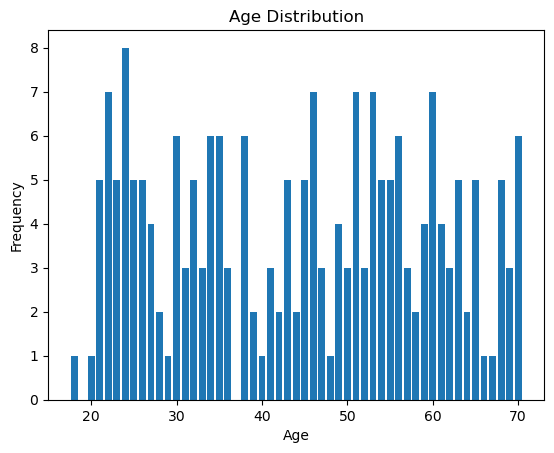

In [20]:
# Get the unique age and its frequency
unique_age = merged_df['age'].unique()
age_counts = merged_df['age'].value_counts()
print(merged_df['age'].describe())

# Plot the distribution
plt.bar(unique_age, age_counts)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

# Save the figure
plt.savefig(f'../images/viz_demographics.png')

# Display the plot
plt.show()

### Distribution of diagnoses

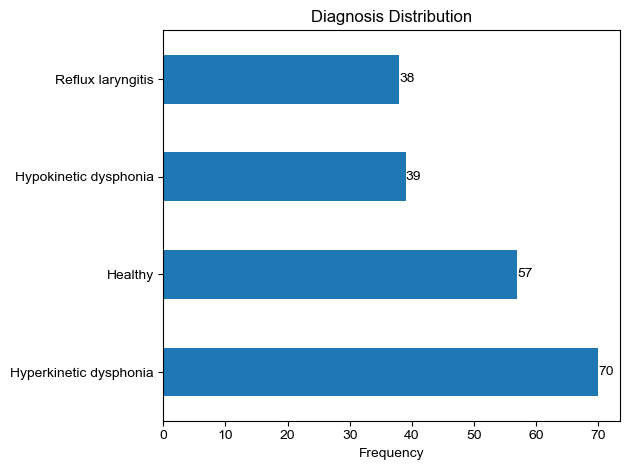

In [27]:
# Plot the distribution
diagnosis_counts = merged_df['diagnosis'].value_counts()
ax = diagnosis_counts.plot(kind='barh')

# Adjust labels
plt.title("Diagnosis Distribution")
plt.xlabel("Frequency")
plt.ylabel("")

# Update the y-tick labels
ytick_pos, ytick_labels = plt.yticks()
clean_labels = [label.get_text().capitalize() for label in ytick_labels]
plt.yticks(ytick_pos, clean_labels)

# Add the value on the bar
for index, value in enumerate(diagnosis_counts):
    ax.text(
        x = value,
        y = index,
        s = str(value),
        ha = 'left',
        va = 'center'
    )

# Save the figure
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.tight_layout()
plt.savefig(f'../images/viz_diagnosis_distribution.png')

# Display the plot
plt.show()

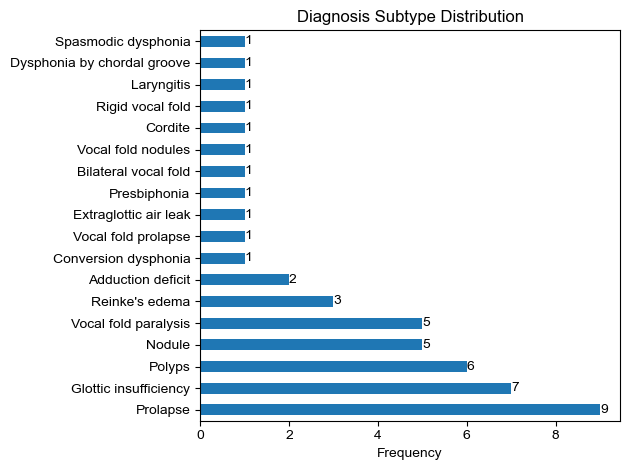

In [28]:
# Calculate the frequency of samples with a subtype
subtypes = merged_df.loc[merged_df['subtype'] != 'no subtype', 'subtype'].copy()
subtype_counts = subtypes.value_counts()

# Plot the subtype distribution
ax = subtype_counts.plot(kind='barh')

# Adjust labels
plt.title("Diagnosis Subtype Distribution")
plt.xlabel("Frequency")
plt.ylabel("")

# Update the y-tick labels
ytick_pos, ytick_labels = plt.yticks()
clean_labels = [label.get_text().capitalize() for label in ytick_labels]
plt.yticks(ytick_pos, clean_labels)

# Add the value on the bar
for index, value in enumerate(subtype_counts):
    ax.text(
        x = value,
        y = index,
        s = str(value),
        ha = 'left',
        va = 'center'
    )

# Save the figure
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.tight_layout()
plt.savefig(f'../images/viz_subtype_distribution.png')

# Display the plot
plt.show()

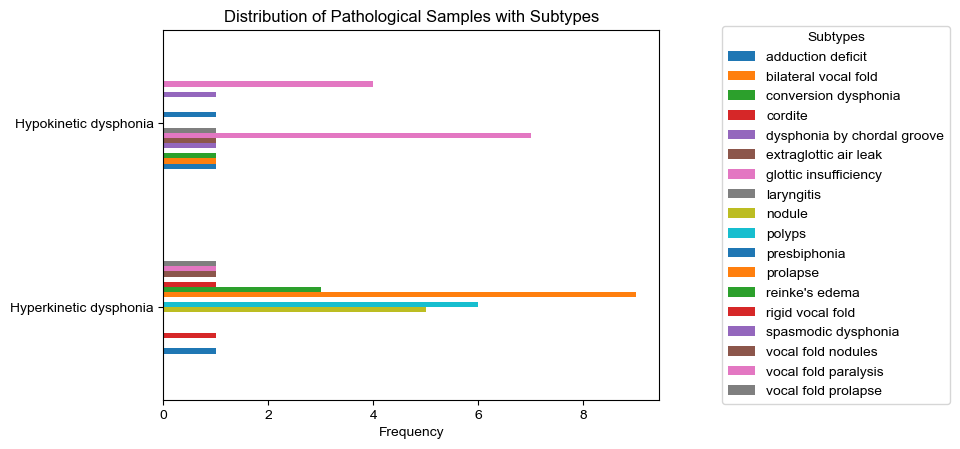

In [30]:
# Get the diagnosis and subtype of pathological samples
cols = ['diagnosis', 'subtype']
condition_1 = (merged_df['diagnosis'] != 'healthy') # pathological only
condition_2 = (merged_df['subtype'] != 'no subtype') # only with subtypes
full_diagnosis = merged_df.loc[condition_1 & condition_2, cols].copy()

# Group by diagnosis then subtype
grouped = full_diagnosis.groupby(cols).size().unstack(fill_value=0)

# Plot the grouped distribution
ax = grouped.plot(kind='barh', stacked=False)

# Add labels
plt.title("Distribution of Pathological Samples with Subtypes")
plt.xlabel("Frequency")
plt.ylabel("")

# Update the y-tick labels
ytick_pos, ytick_labels = plt.yticks()
clean_labels = [label.get_text().capitalize() for label in ytick_labels]
plt.yticks(ytick_pos, clean_labels)

# Move the legend next to the canvas
ax.legend(
    loc = 'right',
    bbox_to_anchor = (1.6,0.5),
    title = 'Subtypes'
)

# Display the plot
plt.show()

__OBSERVATION__: `Reflux Laryngitis` has no subtypes.

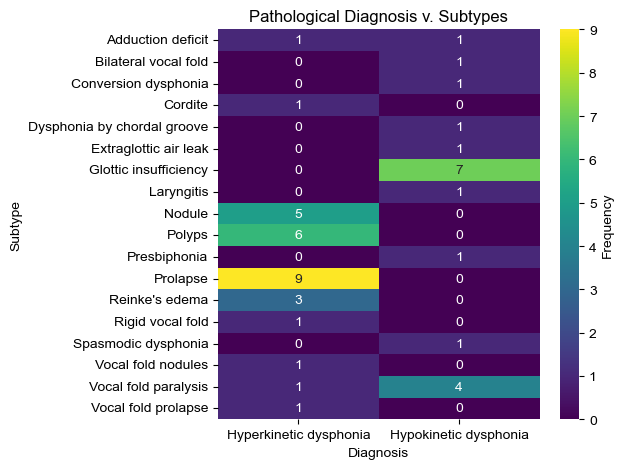

In [31]:
# Improve the previous visualisation
no_subs = ['healthy', 'reflux laryngitis']
condition_1 = (~merged_df['diagnosis'].isin(no_subs))
condition_2 = (merged_df['subtype'] != 'no subtype')

# Get the subset dataframe
full_diagnosis = merged_df.loc[condition_1 & condition_2, cols].copy()

# Group by diagnosis then subtype
grouped = full_diagnosis.groupby(cols).size().unstack(fill_value=0)

# Plot the heatmap of the distribution
hm = sns.heatmap(
    grouped.transpose(),
    annot = True,
    cmap = "viridis",
    cbar_kws = {'label': 'Frequency'}
)

# Add labels
plt.title("Pathological Diagnosis v. Subtypes")
plt.xlabel("Diagnosis")
plt.ylabel("Subtype")

# Update the tick labels
xtick_labels = hm.get_xticklabels()
ytick_labels = hm.get_yticklabels()
hm.set_xticklabels([label.get_text().capitalize() for label in xtick_labels])
hm.set_yticklabels([label.get_text().capitalize() for label in ytick_labels])

# Save the figure
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.tight_layout()
plt.savefig(f'../images/viz_subtype_heatmap.png')

# Display the plot
plt.show()